# Part 3
# Author: Georgios Pligoropoulos < george@pligor.com >

In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from os import path, remove
import numpy as np
import pandas as pd
from csv import QUOTE_ALL
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
import shutil
from sklearn.metrics import r2_score
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import operator
from os.path import isfile, isdir, join
from os import getcwd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE, \
    MatrixFactorization, BiScaler
from math import floor

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
seed = 16011984
random_state = np.random.RandomState(seed=seed)
n_jobs = 1
%matplotlib inline

In [4]:
from advanced_one_hot_encoder import AdvancedOneHotEncoder

**Short sale** explained: http://www.investopedia.com/terms/r/real-estate-short-sale.asp

## Load Data

In [5]:
twin_cities_path = join(getcwd(), 'twin_cities.csv')
df = pd.read_csv(twin_cities_path, delimiter = ',', encoding='utf-8', quoting=QUOTE_ALL, index_col=0)
df.shape

(1111, 20)

## Drop redundant columns
State column does not hold any information since it is the same for all instances
Also we are dropping last sale date as we are advised to not use it but also because it contains lots of nulls

In [6]:
if 'STATE' in df.columns:
    df = df.drop(labels=['STATE'], axis=1)
if 'LastSaleDate' in df.columns:
    df = df.drop(labels=['LastSaleDate'], axis=1)
df.shape

(1111, 18)

### Keep columns for Price Regression

In [7]:
#Regression Columns
#CITY, ZIP, BEDS, BATHS, SQFT, LotSize, YearBuilt, ParkingSpots, HasGarage, LATITUDE, LONGITUDE, ShortSale
XX = df[
    ['CITY', 'ZIP', 'BEDS', 'BATHS', 'SQFT', 'LotSize', 'YearBuilt', 'ParkingSpots', 'HasGarage', 'LATITUDE',
     'LONGITUDE', 'ShortSale']
]
XX.shape

(1111, 12)

In [8]:
#target: ListPrice
yy = df['ListPrice']
yy.shape

(1111,)

### Numerify data

In [9]:
if XX['BATHS'].dtype == 'object':
    XX['BATHS'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['BATHS']]
XX['BATHS'].dtype

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


dtype('float64')

#### CITY

In [10]:
print len(XX['CITY'].unique())
XX['CITY'].unique()

6


array([u'St. Paul', u'Shoreview', u'Minneapolis', u'Woodbury',
       u'West St. Paul', u'Maplewood'], dtype=object)

In [11]:
if 'CITY' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='CITY')
XX.shape

(1111, 16)

#### ZIP

In [12]:
#comparing locations and zips lengths
print len(df['LOCATION'].unique())
print len(df['ZIP'].unique())

86
33


In [13]:
if 'ZIP' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='ZIP')
XX.shape

(1111, 47)

#### Year Built to Age

In [14]:
if 'YearBuilt' in XX.columns:
    XX['age'] = 2014 - XX['YearBuilt']
    XX.drop(labels='YearBuilt', axis=1, inplace=True)
assert 'age' in XX.columns
XX.shape

(1111, 47)

#### Has Garage to binary

In [15]:
XX['HasGarage'].unique()

array([u'Garage', u'No Garage'], dtype=object)

In [16]:
if 'Garage' in XX['HasGarage'].unique():
    XX['HasGarage'] = XX['HasGarage'] == 'Garage'
XX['HasGarage'].unique()

array([True, False], dtype=object)

#### Short Sale to binary

In [17]:
XX['ShortSale'].unique()

array([u'N', u'Y'], dtype=object)

In [18]:
if 'Y' in XX['ShortSale'].unique():
    XX['ShortSale'] = XX['ShortSale'] == 'Y'
XX['ShortSale'].unique()

array([False, True], dtype=object)

#### Latitude

In [19]:
if XX['LATITUDE'].dtype == 'object':
    XX['LATITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LATITUDE']]
XX['LATITUDE'].dtype

dtype('float64')

#### Longitude

In [20]:
if XX['LONGITUDE'].dtype == 'object':
    XX['LONGITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LONGITUDE']]
XX['LONGITUDE'].dtype

dtype('float64')

### Fill the Gaps
Rule of thumb of KNN to pick a neighborhood of 1%

In [21]:
k_factor = int(floor(len(XX) * 0.01))
k_factor

11

In [22]:
if sum(XX.isnull().sum()) > 0:
    XX[XX.columns] = KNN(k=k_factor).complete(XX.values)

Imputing row 1/1111 with 0 missing, elapsed time: 0.393
Imputing row 101/1111 with 1 missing, elapsed time: 0.398
Imputing row 201/1111 with 1 missing, elapsed time: 0.399
Imputing row 301/1111 with 0 missing, elapsed time: 0.400
Imputing row 401/1111 with 0 missing, elapsed time: 0.400
Imputing row 501/1111 with 0 missing, elapsed time: 0.401
Imputing row 601/1111 with 0 missing, elapsed time: 0.401
Imputing row 701/1111 with 0 missing, elapsed time: 0.402
Imputing row 801/1111 with 0 missing, elapsed time: 0.402
Imputing row 901/1111 with 0 missing, elapsed time: 0.403
Imputing row 1001/1111 with 0 missing, elapsed time: 0.403
Imputing row 1101/1111 with 0 missing, elapsed time: 0.404


In [23]:
sum(XX.isnull().sum())

0

# Question 3
Imagine you are an enterprising real estate agent who has the chance to buy up a
bundle of houses for sale – but you can only pick one zip code (either 55104 or 55108).

Also, you can only buy a bundle of properties priced within the middle 50% of the values
– you won’t be able to buy the most expensive houses or the cheapest houses.

Assume the sample of houses in this dataset is representative for those zip codes. If
you had the choice to buy 1000 homes in either 55104 or 55108 which zip code would
you invest in and why? Provide your analysis and reasoning.

#### Answer
**Note** that the term "bundle of houses" we do NOT consider that the houses should be adjacent with each other. They can be wherever in the area.

In [24]:
#first of all we need to pick houses from Q1 to Q3, within that range, that would be neither too cheap
#nor too expensive

#1000 homes, need to do upsampling or use confidence intervals

#what is the representation of where you would invest?

In [25]:
best_alpha = 0.0057223676593502202

In [26]:
model = Ridge(alpha=best_alpha, normalize=True).fit(XX, yy)
model

Ridge(alpha=0.00572236765935, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [27]:
model.score(XX, yy)

0.7808430886161426

In [28]:
zip1 = 55104
zip2 = 55108

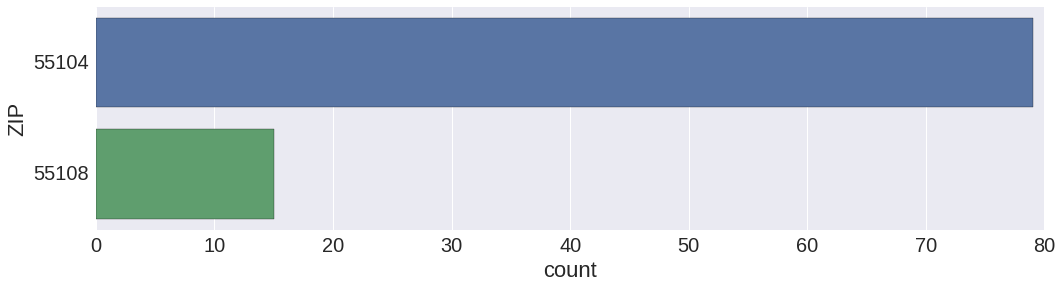

In [29]:
sns.set(font_scale=2)
plt.figure(figsize=(17,4))
sns.countplot(data=df[np.logical_or(df['ZIP'] == zip1, df['ZIP'] == zip2) ], y='ZIP')
plt.show()

In [30]:
zip_inds1 = df[df['ZIP'] == zip1].index
zip_inds1.shape

(79,)

In [31]:
zip_inds2 = df[df['ZIP'] == zip2].index
zip_inds2.shape

(15,)

## Quartiles for keeping only around 50%

In [32]:
df_1 = df[df['ZIP'] == zip1]
df_2 = df[df['ZIP'] == zip2]
df_1.shape, df_2.shape

((79, 18), (15, 18))

In [33]:
aa = np.concatenate( (np.arange(5,15), np.arange(100,105)) )
aa

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14, 100, 101, 102,
       103, 104])

In [34]:
np.mean(aa)

40.333333333333336

In [35]:
np.percentile(aa, 75)

100.5

In [36]:
Q1_1 = np.percentile(df_1['ListPrice'], 25)
Q1_1

129900.0

In [37]:
Q3_1 = np.percentile(df_1['ListPrice'], 75)
Q3_1

200450.0

In [38]:
Q1_2 = np.percentile(df_2['ListPrice'], 25)
Q1_2

184700.0

In [39]:
Q3_2 = np.percentile(df_2['ListPrice'], 75)
Q3_2

244949.5

In [46]:
df_filtered_1 = df_1[np.logical_and(df_1['ListPrice'] >= Q1_1, df_1['ListPrice'] <= Q3_1)]
df_filtered_1.shape

(41, 18)

In [48]:
df_filtered_2 = df_2[np.logical_and(df_2['ListPrice'] >= Q1_2, df_2['ListPrice'] <= Q3_2)]
df_filtered_2.shape

(7, 18)

#### Conclusion
We notice that we have a very small sample of houses from area with zip code 55108

# Get the samples of the potentials of each area of specific zip code

In [49]:
XX_1 = XX.loc[df_filtered_1.index]
XX_2 = XX.loc[df_filtered_2.index]
XX_1.shape, XX_2.shape

((41, 47), (7, 47))

In [50]:
potentials_1 = model.predict(XX_1) - yy[df_filtered_1.index]
potentials_1.shape

(41,)

In [51]:
potentials_2 = model.predict(XX_2) - yy[df_filtered_2.index]
potentials_2.shape

(7,)

# Get the confidence intervals for each case
Note that we are considering 1000 homes a large number, large enough to have the limit theorem in place and consider a gaussian distribution

In [52]:
avg1 = np.mean(potentials_1)
std1 = np.std(potentials_1)
avg1, std1

(-48069.38258225234, 65152.25787155514)

In [53]:
avg2 = np.mean(potentials_2)
std2 = np.std(potentials_2)
avg2, std2

(-23309.88031690887, 68104.79000347792)

On a first view looking at the averages alone it seems that 55108 is the best of the two area for real estate investments. But let's look how confident we are about this result

In [54]:
from confidence_interval import ConfidenceInterval

Let's see what is the confidence level for getting an investment in area two that is always better than the average value of area one

In [55]:
diff = abs(avg2 - avg1)
diff

24759.50226534347

In [56]:
min_mean_2 = avg2 - diff
min_mean_2

-48069.38258225234

In [57]:
max_mean_2 = avg2 + diff
max_mean_2

1449.6219484346002

In [58]:
cf = ConfidenceInterval()

In [59]:
percent = cf.getPercentageForConfidenceInterval(N_sample=len(potentials_2), sample_mean=avg2, sample_std=std2,
                                     min_mean=min_mean_2, max_mean=max_mean_2)
percent

0.66388163204067641

So we will be basing our investment with a relatively large uncertainty since we are confident only ~66% or in other words 2/3

Let's increase our confidence level to 90% and see what happens for both

In [60]:
ci1 = cf.getConfidenceInterval(percentage=.9, sample_mean=avg1, sample_std=std1, N_sample=len(potentials_1))
ci1

(-64805.888651837879, -31332.876512666815)

In [61]:
ci2 = cf.getConfidenceInterval(percentage=.9, sample_mean=avg2, sample_std=std2, N_sample=len(potentials_2))
ci2

(-65650.371799048124, 19030.611165230359)

Now we are highly confident that the average potential for one area and the other is within this range.

We notice that the lower boundary is about the same but the higher boundary for the area 2 is much higher and it has a possibility of a high potential.

The investment is better to be made in area2 with **postcode: 55108** given that the area has lots of available houses

# Repeating with hacker statistics

In [98]:
get_avg_pot = lambda inputs, targets : np.mean(model.predict(inputs)) - targets

In [99]:
from bootstrap_replicates import draw_bootstrap_replicates

In [100]:
XX_1.shape, XX_2.shape

((41, 47), (7, 47))

In [101]:
XX_1.shape

(41, 47)

In [102]:
np.array(XX_1).shape

(41, 47)

In [105]:
%%time
replicates_55104 = draw_bootstrap_replicates(get_avg_pot, 10000, random_state, XX_1, yy[df_filtered_1.index])
#get_avg_pot(XX_2)
len(replicates_55104)

CPU times: user 1.29 s, sys: 4 ms, total: 1.29 s
Wall time: 1.29 s


In [106]:
%%time
replicates_55108 = draw_bootstrap_replicates(get_avg_pot, 10000, random_state, XX_2, yy[df_filtered_2.index])
#get_avg_pot(XX_2)
len(replicates_55108)

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s


In [107]:
np.percentile(replicates_55104, [5, 95])

array([-83408.02469863, -17490.67218572])

In [108]:
np.percentile(replicates_55108, [5, 95])

array([-75927.01677265,  25674.17070822])